Found cached dataset parquet (C:/Users/HououinKyouma/.cache/huggingface/datasets/Maysee___parquet/Maysee--tiny-imagenet-35af7c46a941f08e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([128, 3, 64, 64])


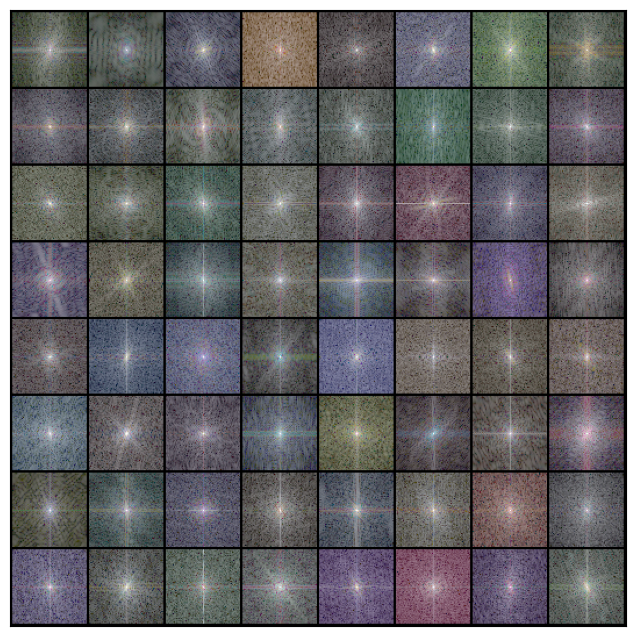

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.utils import save_image
from tqdm.notebook import tqdm
from dataset import Dataset
from configuration import config


batch_size = config.dataloader.batch_size
ds = Dataset.load(**config.dataset)
dataloader = ds.dataloader(**config.dataloader, type='train', domain='frequency')

def denormalize(images):
  return images * 0.5 + 0.5

def show_images(images):
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([])
  ax.set_yticks([])

  ax.imshow(make_grid(denormalize(images.detach()[:64]), nrow=8).permute(1, 2, 0))

def show_batch(dataloader):
  for (images, _) in dataloader:
    print(images.shape)
    show_images(images)
    break

show_batch(dataloader)

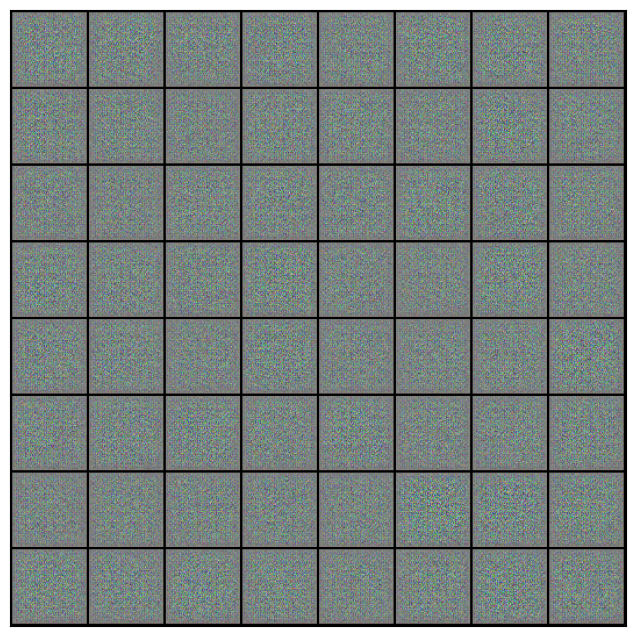

In [2]:
from discriminator import Discriminator
from generator import Generator
from weights import initialize_weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
discriminator = Discriminator(use_gpu=config.use_gpu).apply(initialize_weights).to(device)
generator = Generator(use_gpu=config.use_gpu).apply(initialize_weights).to(device)

latent_size = 128
noises = torch.randn(batch_size, latent_size, 1, 1).to(device)
noise_images = generator(noises)

show_images(noise_images.cpu())

In [ ]:
def train_discriminator(images, optimizer):
  optimizer.zero_grad()

  images_predictions = discriminator(images)
  images_targets = torch.ones(images.size(0), 1, device=device)
  images_loss = F.binary_cross_entropy(images_predictions, images_targets)
  images_score = torch.mean(images_predictions).item()

  noises = torch.randn(batch_size, latent_size, 1, 1, device=device)
  noises_images = generator(noises)

  noises_targets = torch.zeros(noises_images.size(0), 1, device=device)
  noises_predictions = discriminator(noises_images)
  noises_loss = F.binary_cross_entropy(noises_predictions, noises_targets)
  noises_score = torch.mean(noises_predictions).item()

  loss = images_loss + noises_loss
  loss.backward()
  optimizer.step()

  return loss.item(), images_score, noises_score

def train_generator(optimizer):
  optimizer.zero_grad()

  noises = torch.randn(batch_size, latent_size, 1, 1, device=device)
  noises_images = generator(noises)

  predictions = discriminator(noises_images)
  targets = torch.ones(batch_size, 1, device=device)
  loss = F.binary_cross_entropy(predictions, targets)

  loss.backward()
  optimizer.step()

  return loss.item()

def save_samples(index, latent_tensors, show=True):
  noise_images = generator(latent_tensors)
  noise_filename = f'generated-images-{index:0=4d}.png'

  save_image(denormalize(noise_images), os.path.join(sluts_directory, noise_filename), nrow=8)
  print(f'Saving {noise_filename}')

  if show:
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(noise_images.cpu().detach(), nrow=8).permute(1, 2, 0))

def fit(discriminator, generator, dataloader, epochs, learning_rate):
  torch.cuda.empty_cache()

  losses_generator = []
  losses_discriminator = []
  images_scores = []
  noises_scores = []

  optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
  optimizer_generator = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

  for epoch in range(epochs):
    for images_images, _ in tqdm(dataloader):
      images_images = images_images.to(device)

      loss_discriminator, images_score, noises_score = train_discriminator(images_images, optimizer_discriminator)
      loss_generator = train_generator(optimizer_generator)

    losses_generator.append(loss_generator)
    losses_discriminator.append(loss_discriminator)
    images_scores.append(images_score)
    noises_scores.append(noises_score)

    print(
      f"Epoch [{epoch + 1}/{epochs}]"
      f" loss_generator: {loss_generator:.4f}"
      f" loss_discriminator: {loss_discriminator:.4f}"
      f" images_score: {images_score:.4f}"
      f" noises_score: {noises_score:.4f}"
    )

    save_samples(epoch, constant_noise, show=False)

  return losses_generator, losses_discriminator, images_scores, noises_scores
learning_rate = 0.0002
epochs = 600

sluts_directory = 'generated'
os.makedirs(sluts_directory, exist_ok=True)
constant_noise = torch.randn(64, latent_size, 1, 1, device=device)
save_samples(0, constant_noise)

history = fit(
  discriminator,
  generator,
  dataloader,
  epochs=epochs,
  learning_rate=learning_rate
)
losses_generator, losses_discriminator, image_scores, noise_scores = history
from IPython.display import Image
Image('./generated/generated-images-00600.png')


In [39]:
torch.save(generator.state_dict(), 'frequency-generator.pt')
torch.save(discriminator.state_dict(), 'frequency-discriminator.pt')

In [3]:
generator.load_state_dict(torch.load('frequency-generator.pt'))
discriminator.load_state_dict(torch.load('frequency-discriminator.pt'))

<All keys matched successfully>

In [16]:
from numpy import min, max, log, abs, stack, uint8 as u8
from numpy.fft import fft2, fftshift, ifft, ifftshift


def ifft(image):
  red_magnitude = image[:, :, 0]
  green_magnitude = image[:, :, 1]
  blue_magnitude = image[:, :, 2]

  red_magnitude = red_magnitude * (max(red_magnitude) - min(red_magnitude)) + min(red_magnitude)
  green_magnitude = green_magnitude * (max(green_magnitude) - min(green_magnitude)) + min(green_magnitude)
  blue_magnitude = blue_magnitude * (max(blue_magnitude) - min(blue_magnitude)) + min(blue_magnitude)

  red_shift = ifftshift(red_magnitude)
  green_shift = ifftshift(green_magnitude)
  blue_shift = ifftshift(blue_magnitude)
  print(red_magnitude)
  red_fft = ifft(red_shift)
  green_fft = ifft(green_shift)
  blue_fft = ifft(blue_shift)

  red = abs(red_fft)
  green = abs(green_fft)
  blue = abs(blue_fft)

  return stack([red, green, blue], axis=2)

# noise = torch.randn(1, latent_size, 1, 1, device=device)

# image = generator(noise).squeeze(0).detach().cpu().numpy()

# image = inverse_ifft_magnitude(image)

# plt.figure(figsize=(8, 8))
# plt.imshow(image)
# plt.show()
X, y = zip(*ds.train)

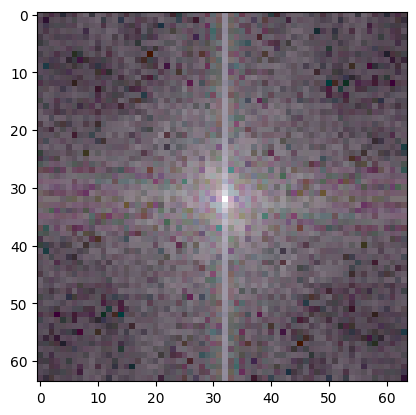

(64, 64, 3)
(64, 64)
(64, 64)
(64, 64)


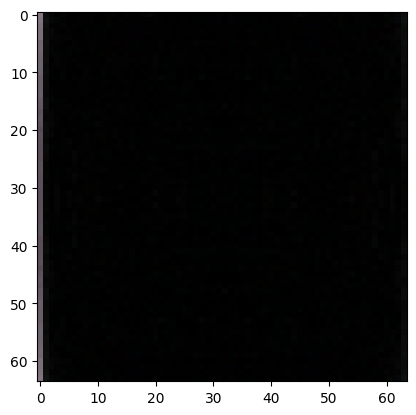

In [45]:
import numpy as np
from numpy import min, max, log, abs, stack, uint8 as u8, asarray
from numpy.fft import fft2, fftshift, ifft, ifftshift


def fft(image):
  image = asarray(image)

  red_fft = fft2(image[:, :, 0])
  green_fft = fft2(image[:, :, 1])
  blue_fft = fft2(image[:, :, 2])

  red_shift = fftshift(red_fft)
  green_shift = fftshift(green_fft)
  blue_shift = fftshift(blue_fft)

  red_magnitude = log(abs(red_shift) + 1)
  green_magnitude = log(abs(green_shift) + 1)
  blue_magnitude = log(abs(blue_shift) + 1)
  red_magnitude = (
      (red_magnitude - min(red_magnitude)) / (max(red_magnitude) - min(red_magnitude))
  )
  green_magnitude = (
      (green_magnitude - min(green_magnitude)) / (max(green_magnitude) - min(green_magnitude))
  )
  blue_magnitude = (
      (blue_magnitude - min(blue_magnitude)) / (max(blue_magnitude) - min(blue_magnitude))
  )

  return stack([red_magnitude, green_magnitude, blue_magnitude], axis=2)

def inverse_fft(image):
  print(image.shape)
  red_magnitude = image[:, :, 0]
  green_magnitude = image[:, :, 1]
  blue_magnitude = image[:, :, 2]

  red_magnitude = red_magnitude * (max(red_magnitude) - min(red_magnitude)) + min(red_magnitude)
  green_magnitude = green_magnitude * (max(green_magnitude) - min(green_magnitude)) + min(green_magnitude)
  blue_magnitude = blue_magnitude * (max(blue_magnitude) - min(blue_magnitude)) + min(blue_magnitude)

  red_shift = ifftshift(red_magnitude)
  green_shift = ifftshift(green_magnitude)
  blue_shift = ifftshift(blue_magnitude)

  red_fft = ifft(red_shift)
  green_fft = ifft(green_shift)
  blue_fft = ifft(blue_shift)

  red = np.abs(red_fft)
  green = np.abs(green_fft)
  blue = np.abs(blue_fft)
  print(red.shape)
  print(green.shape)
  print(blue.shape)

  return stack([red, green, blue], axis=2)

img = X[0]
img = fft(img)
plt.imshow(img)
plt.show()
img = inverse_fft(img)
plt.imshow(img)
plt.show()


In [ ]:
video_filename = 'gans_training.avi'

files = [os.path.join(sluts_directory, file) for file in os.listdir(sluts_directory) if 'generated' in file]
files.sort()

video = cv2.VideoWriter(video_filename, cv2.VideoWriter_fourcc(*'MP4V'), 1, (530, 530))
for filename in files: video.write(cv2.imread(filename))
video.release()


In [37]:
from numpy import min, max, log, abs, stack, uint8 as u8
from numpy.fft import fft2, fftshift, ifft, ifftshift


def inverse_ifft_magnitude(image):
  red_magnitude = image[:, :, 0]
  green_magnitude = image[:, :, 1]
  blue_magnitude = image[:, :, 2]

  red_magnitude = red_magnitude * (max(red_magnitude) - min(red_magnitude)) + min(red_magnitude)
  green_magnitude = green_magnitude * (max(green_magnitude) - min(green_magnitude)) + min(green_magnitude)
  blue_magnitude = blue_magnitude * (max(blue_magnitude) - min(blue_magnitude)) + min(blue_magnitude)

  red_shift = ifftshift(red_magnitude)
  green_shift = ifftshift(green_magnitude)
  blue_shift = ifftshift(blue_magnitude)

  red_fft = ifft(red_shift)
  green_fft = ifft(green_shift)
  blue_fft = ifft(blue_shift)

  red = abs(red_fft)
  green = abs(green_fft)
  blue = abs(blue_fft)

  return stack([red, green, blue], axis=2)

noise = torch.randn(1, latent_size, 1, 1, device=device)

image = generator(noise).squeeze(0).detach().cpu().numpy()

image = inverse_ifft_magnitude(image)

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.show()